In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Splitting Data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
hotel = pd.read_csv('/Users/zaki/Downloads/hotel_bookings 2.csv',
                    usecols = ['hotel', 'is_canceled', 'adults', 'children', 'babies', 'meal', 'country',
                               'market_segment', 'distribution_channel', 'reserved_room_type', 'booking_changes',
                               'deposit_type', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces',
                               'total_of_special_requests'])[:5000]
hotel

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,0,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,0,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,D,0,Non Refund,0,Transient,0,0
4996,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,D,0,Non Refund,0,Transient,0,0
4997,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,A,0,Non Refund,0,Transient,0,0
4998,Resort Hotel,1,2,0.0,0,HB,PRT,Groups,Direct,A,0,Non Refund,0,Transient,0,0


In [3]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        5000 non-null   object 
 1   is_canceled                  5000 non-null   int64  
 2   adults                       5000 non-null   int64  
 3   children                     5000 non-null   float64
 4   babies                       5000 non-null   int64  
 5   meal                         5000 non-null   object 
 6   country                      4998 non-null   object 
 7   market_segment               5000 non-null   object 
 8   distribution_channel         5000 non-null   object 
 9   reserved_room_type           5000 non-null   object 
 10  booking_changes              5000 non-null   int64  
 11  deposit_type                 5000 non-null   object 
 12  days_in_waiting_list         5000 non-null   int64  
 13  customer_type     

# EDA

In [4]:
hotel_eda = hotel.copy()

In [5]:
hotel_eda['hotel'].value_counts()

Resort Hotel    5000
Name: hotel, dtype: int64

- In this data, the type of hotel is only Resort Hotel, because I only use 5000 first rows of data.

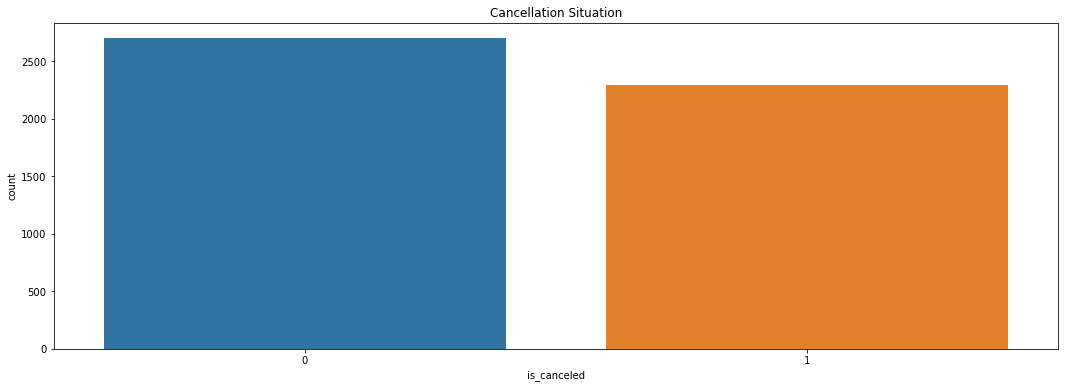

In [58]:
plt.figure(figsize=(18,6))
sns.countplot(x='is_canceled', data= hotel_eda)
plt.title('Cancellation Situation')
plt.show()

In [7]:
hotel_eda['is_canceled'].value_counts()/hotel.shape[0]*100

0    54.04
1    45.96
Name: is_canceled, dtype: float64

- The difference ratio between cancel and not cancel tends to be even with:
    * Not Cancel: 54,04%
    * Cancel: 45,96%

### Customer Profiling

In [8]:
hotel_eda['all_children'] = hotel_eda['children'] + hotel_eda['babies']
pd.crosstab(hotel_eda['adults'], hotel_eda['all_children'], margins=True, margins_name = 'Total')

all_children,0.0,1.0,2.0,3.0,10.0,Total
adults,,,,,,
0,6,0,0,0,0,6
1,642,7,5,0,0,654
2,3777,201,195,1,1,4175
3,116,29,1,0,0,146
4,3,0,0,0,0,3
5,2,0,0,0,0,2
6,1,0,0,0,0,1
10,1,0,0,0,0,1
20,2,0,0,0,0,2


- Pada data ini, saya menggabungkan antara children dan babies pada kolom all_children untuk mempermudah perhitungan.

#### Adults
- Dilihat pada data di atas, mayoritas dewasa yang datang berjumlah 2 orang sebanyak 4175 dan yang tanpa membawa anak sebanyak 3777. Ada kemungkinan memiliki tujuan untuk urusan bisnis, atau pasangan yang sedang honeymoon.
- Di urutan kedua adalah dewasa yang datang sendirian sebanyak 654 dan yang tanpa membawa anak sebanyak 642. Ada kemungkinan memiliki tujuan untuk urusan bisnis.
- Untuk dewasa yang datang lebih dari 4 dewasa, tidak ada yang membawa anak satupun. Ada kemungkinan memiliki tujuan untuk urusan bisnis, atau travelling.

#### All Children
- Pada data di atas, mayoritas dewasa yang datang tanpa membawa anak sebanyak 4560, di susul dengan yang membawa 1 anak sebanyak 237 dewasa dan 2 anak sebanyak 201 dewasa.

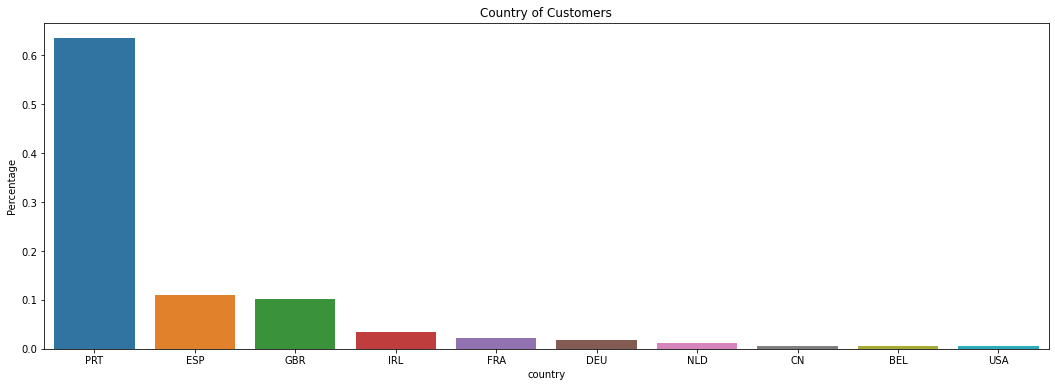

In [73]:
plt.figure(figsize=(18,6))
country_booking = hotel_eda['country'].value_counts(normalize=True).rename_axis('country').reset_index(name='Percentage')
sns.barplot(x='country', y='Percentage', data=country_booking.head(10))
plt.title('Country of Customers')
plt.show()

- Categories are represented in the ISO 3155–3:2013 format.
- PRT or Portugal has the most booking demand based on the data (more than 60%). It is pretty obvious because if we trace to the publication page, the description tells us that the data source locations are from hotels located in Portugal.

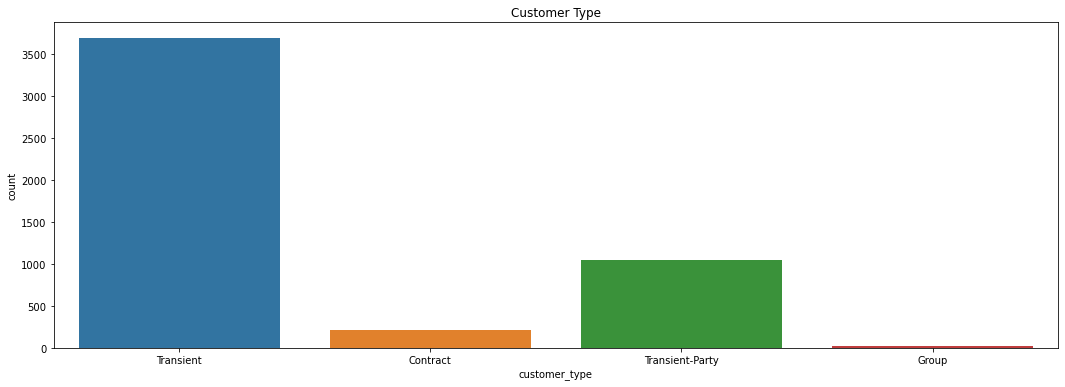

In [46]:
plt.figure(figsize=(18,6))
sns.countplot(x='customer_type', data= hotel_eda)
plt.title('Customer Type')
plt.show()

In [47]:
hotel_eda['customer_type'].value_counts()/len(hotel_eda['customer_type'])*100

Transient          73.98
Transient-Party    21.14
Contract            4.38
Group               0.50
Name: customer_type, dtype: float64

Type of booking, assuming one of four categories:
- Contract, when the booking has an allotment or other type of contract associated to it
- Group, when the booking is associated to a group
- Transient, when the booking is not part of a group or contract, and is not associated to other transient booking
- Transient-party, when the booking is transient, but is associated to at least other transient booking

From the graph:
- Transient as much as 73.98%
- Transient-party as much as 21.14%
- Contract as much as 4.38%
- Group as much as 0.50%

Most of customers is Transient, means they are walk-in guests, last-minute or bookers, or simply people that require a very short-term stay in your facility. Transient customers are one of the major market segments consist of individuals or groups.

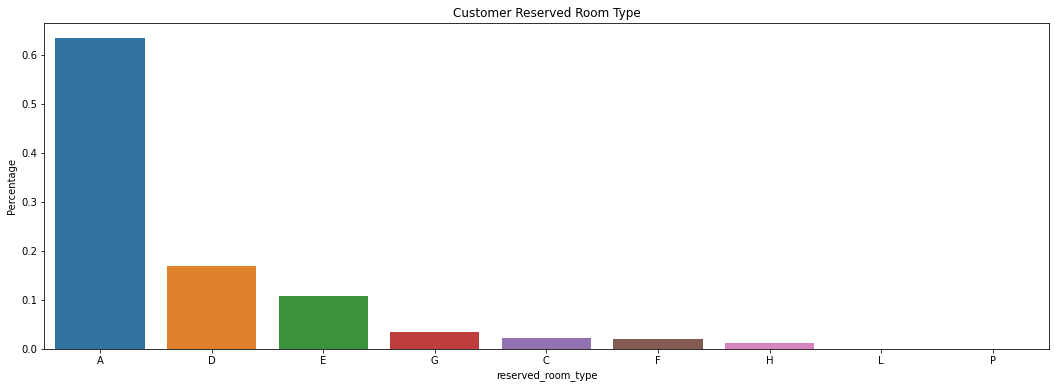

In [70]:
plt.figure(figsize=(18,6))
room_booking = hotel_eda['reserved_room_type'].value_counts(normalize=True).rename_axis('reserved_room_type').reset_index(name='Percentage')
sns.barplot(x='reserved_room_type', y='Percentage', data= room_booking)
plt.title('Customer Reserved Room Type')
plt.show()

- Type of Reserved Room is A, D, E, G, C, F, H, L, P. Code is presented instead of designation for anonymity reasons.
- Most of customers book the type A room more than 60%.

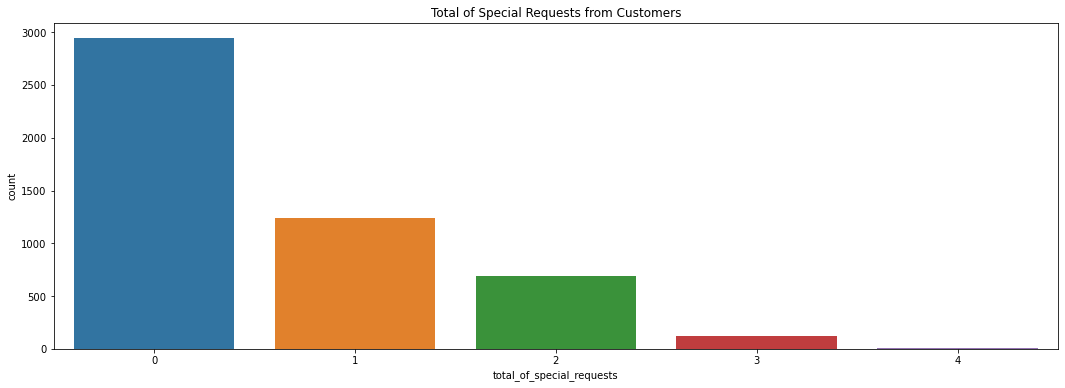

In [74]:
plt.figure(figsize=(18,6))
sns.countplot(x='total_of_special_requests', data= hotel_eda)
plt.title('Total of Special Requests from Customers')
plt.show()

- Number of special requests made by the customer (e.g. twin bed or high floor)
- Most customers don't make any special requests. It has a correlation with customer type. They don't ask for any additional requests because they only transient customers.

### Customer Behavior

In [44]:
hotel_eda['meal'].value_counts()/len(hotel_eda['meal'])*100

BB           68.36
HB           20.74
FB            6.38
Undefined     4.24
SC            0.28
Name: meal, dtype: float64

Type of meal booked. Categories are presented in standard hospitality meal packages: 
- BB means Bed & Breakfast as much as 68.36%
- HB means Half board (breakfast and one other meal – usually dinner) as much as 20.74%
- FB means Full board (breakfast, lunch and dinner) as much as 6.38%
- Undefined/SC means no meal as much as 4.52%

Most customers prefer to book include Breakfast, which's the usual complimentary if someone wants to book a hotel. In case they don't have time to find breakfast outside the hotel. Some of them around 20.74% book with another meal, usually dinner. Them who came with business interests can get more resting time to not find any dinner outside hotel anymore.

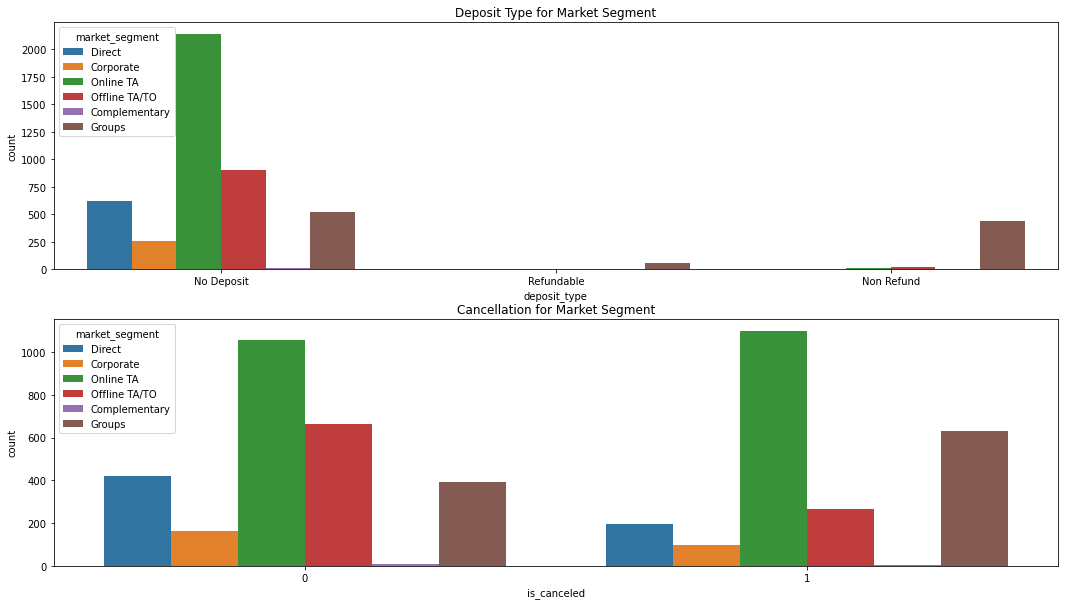

In [75]:
plt.figure(figsize=(18,10))
plt.subplot(211)
sns.countplot(data=hotel_eda,x='deposit_type',hue='market_segment')
plt.title('Deposit Type for Market Segment')
plt.subplot(212)
sns.countplot(data=hotel_eda,x='is_canceled',hue='market_segment')
plt.title('Cancellation for Market Segment')
plt.show()

#### Deposit Type for Market Segment
- The highest book is using Online TA, with No Deposit. While Groups and Offline TA/TO are next with Refundable and Non refund. In this era, it will be easy to book a hotel using Online TA, especially most Online TA offers the customers without deposit facility. Customers can choose any type of room up to any special request by Online TA.
- Looking at Offline TA/TO and Groups, the situations where the deposit was received were only in the scenarios where the groups came. It is quite logical to apply a deposit for a large number of customers who will fill important amount of the hotel capacity.

#### Cancellation for Market Segment
- The highest cancellation book is using Online TA. Most of Online TA give a customers previllege to cancel without any charge apply. Second, Groups segment has cancellation rate around 50%.

# Data Cleaning

In [14]:
hotel.isna().sum()/len(hotel)*100

hotel                          0.00
is_canceled                    0.00
adults                         0.00
children                       0.00
babies                         0.00
meal                           0.00
country                        0.04
market_segment                 0.00
distribution_channel           0.00
reserved_room_type             0.00
booking_changes                0.00
deposit_type                   0.00
days_in_waiting_list           0.00
customer_type                  0.00
required_car_parking_spaces    0.00
total_of_special_requests      0.00
dtype: float64

* There is a column that has 0.04% of missing value. Will process is on ColumnTransformer.

# PreProcessing

*Preprocessing Scheme*

- OneHot: hotel, meal, market_segment, distribution_channel, reserved_room_type, deposit_type, customer_type
- Binary:
    * mode: country (country column more than 10 countries, soI decide to use binary)
- PassThrough: adults, children, babies, booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_requests
- Target: is_canceled
- No need to scale the data because there isn't any interval nominal between columns

In [16]:
mode_binary = Pipeline([
    ('encoder', SimpleImputer(strategy = 'most_frequent')),
    ('binary', BinaryEncoder())
])

transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(handle_unknown = 'ignore'), [ 'hotel', 'meal', 'market_segment', 'distribution_channel',
                                                           'reserved_room_type', 'deposit_type', 'customer_type']),
    ('mode binary', mode_binary, ['country'])
], remainder = 'passthrough')

*Define Target Data*

In [17]:
hotel['is_canceled'].value_counts()

0    2702
1    2298
Name: is_canceled, dtype: int64

- The data doesn't indicated imbalance

In [18]:
X = hotel.drop('is_canceled', axis = 1)
y = hotel['is_canceled']

* *0 = Not Canceled*
* *1 = Canceled*

        - TN: Guest's predict with Not Canceled and the actual is Not Canceled
        - TP: Guest's predict with Canceled and the actual is Canceled
        - FP: Guest's predict with Canceled and the actual is Not Canceled
        - FN: Guest's predict with Not Canceled and the actual is Canceled

Tindakan:
* FP: Ketika customer datang, kamar tidak tersedia. Customer tidak akan booking ke hotel tersebut karena di anggap memberikan pelayanan yang kurang baik, Hotel mengalami kerugian finansial dan nama baik
* FN: Hotel jadi memiliki kelebihan kamar kosong karena di batalkan, customer memiliki previllege untuk memilih fasilitas lebih jika ingin

- > Yang akan di tekan adalah FP, precision

*Splitting Data*

In [19]:
X.shape

(5000, 15)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify = y,
                                                    test_size = 0.2,
                                                   random_state = 1515)

- I use 0.2 as default score for test_size and X.shape for random_state so the data will be devided equally.

# Modeling

*Define Model*
- I use 3 basic models to predict:
    * Logistic Regression
    * Decision Tree Classifier
    * K-Nearest Neighbor (I add scaler because usually, the score will be better if using a scaler)

In [21]:
logreg = LogisticRegression()
tree = DecisionTreeClassifier(random_state = 1515)
knn = KNeighborsClassifier()

### Cross Validation

In [22]:
logreg_pipe = Pipeline([('transformer', transformer), ('logreg', logreg)])
tree_pipe = Pipeline([('transformer', transformer), ('tree', tree)])
knn_pipe = Pipeline([('transformer', transformer), ('scale', MinMaxScaler()), ('knn', knn)])

def model_evaluation(model, metric):
    model_cv = cross_val_score(model, X_train, y_train, cv = StratifiedKFold(n_splits = 5), scoring = metric)
    return model_cv

logreg_pipe_cv = model_evaluation(logreg_pipe, 'precision')
tree_pipe_cv = model_evaluation(tree_pipe, 'precision')
knn_pipe_cv = model_evaluation(knn_pipe, 'precision')

for model in [logreg_pipe, tree_pipe, knn_pipe]:
    model.fit(X_train, y_train)
    
score_mean = [logreg_pipe_cv.mean(), tree_pipe_cv.mean(), knn_pipe_cv.mean()]
score_std = [logreg_pipe_cv.std(), tree_pipe_cv.std(), knn_pipe_cv.std()]
score_precision_score = [precision_score(y_test, logreg_pipe.predict(X_test)),
            precision_score(y_test, tree_pipe.predict(X_test)), 
            precision_score(y_test, knn_pipe.predict(X_test))]
method_name = ['Logistic Regression', 'Decision Tree Classifier', 'KNN Classifier']
cv_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'precision score': score_precision_score
})
cv_summary

,method,mean score,std score,precision score
0,Logistic Regression,0.782203,0.005937,0.783636
1,Decision Tree Classifier,0.810071,0.014007,0.816929
2,KNN Classifier,0.784107,0.003694,0.783366


- From this method, I will choose Decision Tree Classifier because it has the highest precision score. Even the score is already good, let's see how well the score after processed with Ensemble model.

*Define Ensemble Model*

There are 2 methods in Ensemble Model that I will use:
- Bagging, Training individual model in a parallel way. Each model is trained by a random subset of the data.
    * Random Forest Classifier
- Boosting, Training individual model in a sequential way. Each individual model learns from mistakes made by the previous model.
    * Gradient Boost Classifier
    * Ada Boost Classifier (using Decision Tree Classifier)

### Let’s grow some “trees”.

In [23]:
ada = AdaBoostClassifier(tree, random_state = 1515)
grad = GradientBoostingClassifier(random_state = 1515)
rf = RandomForestClassifier(random_state = 1515)

### Cross Validation

In [24]:
ada_pipe = Pipeline([('transformer', transformer), ('ada', ada)])
grad_pipe = Pipeline([('transformer', transformer), ('grad', grad)])
rf_pipe = Pipeline([('transformer', transformer), ('rf', rf)])

def model_evaluation(model, metric):
    model_cv = cross_val_score(model, X_train, y_train, cv = StratifiedKFold(n_splits = 5), scoring = metric)
    return model_cv

ada_pipe_cv = model_evaluation(ada_pipe, 'precision')
grad_pipe_cv = model_evaluation(grad_pipe, 'precision')
rf_pipe_cv = model_evaluation(rf_pipe, 'precision')

for model in [ada_pipe, grad_pipe, rf_pipe]:
    model.fit(X_train, y_train)
    
score_mean = [ada_pipe_cv.mean(), grad_pipe_cv.mean(), rf_pipe_cv.mean()]
score_std = [ada_pipe_cv.std(), grad_pipe_cv.std(), rf_pipe_cv.std()]
score_precision_score = [precision_score(y_test, ada_pipe.predict(X_test)),
            precision_score(y_test, grad_pipe.predict(X_test)), 
            precision_score(y_test, rf_pipe.predict(X_test))]
method_name = ['Ada Boost Classifier', 'Gradient Boosting Classifier', 'Random Forest Classifierr']
boost_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'precision score': score_precision_score
})
boost_summary

,method,mean score,std score,precision score
0,Ada Boost Classifier,0.815617,0.016659,0.815029
1,Gradient Boosting Classifier,0.789825,0.004535,0.793165
2,Random Forest Classifierr,0.818733,0.013248,0.828794


- Some of scores are getting better. The model I choose is Random Forest Classifier. Why I choose this model? Because the ensemble model tends to be more flexible (less bias) and less data-sensitive (less variance).

Based on 2 model proccesing, Cross Validate the basic model and Cross Validate the ensemble model, I pick Random Forest Classifier and continue to HyperParameter Tuning process.

# HyperParam Tuning

In [25]:
estimator = Pipeline([
    ('transformer', transformer),
    ('model', rf)])

hyperparam_space = {
    'model__n_estimators': [20, 30, 50, 70, 100, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [2, 3, 7, 9, 13, 15, 17, 21],
    'model__min_samples_leaf': [2, 3, 4]
}

random = RandomizedSearchCV(
                estimator,
                param_distributions = hyperparam_space,
                cv = StratifiedKFold(n_splits = 5),
                scoring = 'precision',
                n_iter = 10,
                n_jobs = -1)

random.fit(X_train, y_train)

print('best score', random.best_score_)
print('best param', random.best_params_)

best score 0.819833657215093
best param {'model__n_estimators': 30, 'model__min_samples_leaf': 3, 'model__max_depth': 21, 'model__criterion': 'gini'}


- So far, the best score is 0.819 with best parameter:
    * n_estimators: 30
    * min_samples_leaf: 3
    * max_depth: 21
    * criterion: gini

# Before and After Tuning

In [26]:
estimator.fit(X_train, y_train)
y_pred_estimator = estimator.predict(X_test)
before = precision_score(y_test, y_pred_estimator)

random.best_estimator_.fit(X_train, y_train)
y_predict = random.best_estimator_.predict(X_test)
after = precision_score(y_test, y_predict)

score_list = [before, after]
method_name = ['Random Forest Classifier Before Tuning', 'Random Forest Classifier After Tuning']
best_summary = pd.DataFrame({
    'method': method_name,
    'score': score_list
})
best_summary

,method,score
0,Random Forest Classifier Before Tuning,0.828794
1,Random Forest Classifier After Tuning,0.826848


- After tuning process, the score still the same with before tuning, maybe a litle bit higher than after. At the end, I will choose Random Forest Classifier Before Tuning to predict cancellation booking hotel.